## Importing the libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_graphviz

from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

from io import StringIO
from sklearn import tree
import graphviz

from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

## Load and Prepare Data

In [2]:
df=pd.read_csv("train.csv")
df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.shape

(891, 12)

In [5]:
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [6]:
df = df.reindex(columns=['PassengerId','Name','Sex','Age','Pclass','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Survived'])

In [7]:
cross_tab = pd.crosstab(index=[df['Survived'], # First factor to compare
                               df['Sex']], # second factor to compare
                        columns=df['Pclass']) # the factor we want as our "column"
cross_tab

Pclass            1   2    3
Survived Sex                
0        female   3   6   72
         male    77  91  300
1        female  91  70   72
         male    45  17   47

## Data Preprocessing

In [8]:
# 1) Cabin: اگر مقدار داشت =1، اگر NaN بود =0 (کاملاً وکتورایز)
def create_feat_has_cabin(df, col='Cabin'):
    return df[col].notna().astype(int)


In [9]:
# 2) Embarked: پرکردن مقادیر گمشده با مُد؛ اگر مُد نبود، با 'S'
def fill_na_embarked(df, col='Embarked', fallback='S'):
    if df[col].isna().all():
        df[col] = df[col].fillna(fallback)
    else:
        df[col] = df[col].fillna(df[col].mode().iloc[0])
    return df[col]

In [10]:
# 3) FamilySize: (SibSp + Parch + 1) با ایمن‌سازی در برابر NaN
def create_feat_family_size(df):
    return (
        df['SibSp'].fillna(0).astype(int) +
        df['Parch'].fillna(0).astype(int) + 
        1
    )

In [11]:
# 4) IsAlone: اگر FamilySize==1 → 1، وگرنه 0 (وکتورایز)
def create_feat_isalone(df, col='FamilySize'):
    return (df[col] == 1).astype(int)

In [12]:
# ویژگی‌ها
df['HasCabin']   = create_feat_has_cabin(df, 'Cabin')
df['Embarked']   = fill_na_embarked(df, 'Embarked')      # همین کفایت می‌کند؛ دیگر نیازی به fillna جداگانه نیست
df['FamilySize'] = create_feat_family_size(df)
df['IsAlone']    = create_feat_isalone(df, 'FamilySize')

In [13]:
# پرکردن مقادیر گمشده:
# - عددی‌ها با میانه همان ستون
num_cols = df.select_dtypes(include=['number']).columns
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

In [14]:
# - دسته‌ای/رشته‌ای‌ها با مُد هر ستون (اگر مُد نبود، با رشتهٔ 'Unknown')
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for c in cat_cols:
    if df[c].isna().all():
        df[c] = df[c].fillna('Unknown')
    else:
        df[c] = df[c].fillna(df[c].mode().iloc[0])

In [15]:
df['Sex'] = df['Sex'].astype('category').cat.codes.astype(float)
df['Embarked'].replace(to_replace=['S', 'C', 'Q'], value=[1, 2, 3], inplace=True)

In [16]:
def create_feat_categoricalFare(df, colname):
    return pd.qcut(df[colname], 4, labels = [0, 1, 2, 3]).astype(int)
df['CategoricalFare'] = create_feat_categoricalFare(df, 'Fare')

In [17]:
def create_feat_title(df, colname):
    def find_title(z):
        title_search = re.search(' ([A-Za-z]+)\.', z)
        if title_search:
            title = title_search.group(1)
            if title in ['Mlle', 'Ms']:
                return 'Miss'
            elif title in ['Mme', 'Mrs']:
                return 'Mrs'
            elif title=='Mr':
                return 'Mr'           
            else:
                return 'Rare'
        return ""
    
    return_title= df[colname].apply(find_title)
    dict_title = {'Miss': 1, 'Mrs':2, 'Mr':3, 'Rare':4}
    return return_title.replace(dict_title)
df['Title'] = create_feat_title(df, 'Name')

In [18]:
'''
def create_feat_title(df, colname):
    title_map = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Mrs': 'Mrs', 'Mr': 'Mr'}
    default_title = 'Rare'
    
    def find_title(x):
        title_search = re.search(' ([A-Za-z]+)\.', x)
        return title_map.get(title_search.group(1) if title_search else default_title, default_title)
    
    return df[colname].apply(find_title).map({v: i+1 for i, v in enumerate(set(find_title(x) for x in df[colname]))})

df['Title'] = create_feat_title(df, 'Name')
'''

"\ndef create_feat_title(df, colname):\n    title_map = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Mrs': 'Mrs', 'Mr': 'Mr'}\n    default_title = 'Rare'\n    \n    def find_title(x):\n        title_search = re.search(' ([A-Za-z]+)\\.', x)\n        return title_map.get(title_search.group(1) if title_search else default_title, default_title)\n    \n    return df[colname].apply(find_title).map({v: i+1 for i, v in enumerate(set(find_title(x) for x in df[colname]))})\n\ndf['Title'] = create_feat_title(df, 'Name')\n"

In [19]:
df.drop(columns=['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [20]:
df.isnull().sum()

Sex                0
Age                0
Pclass             0
SibSp              0
Parch              0
Fare               0
Embarked           0
Survived           0
HasCabin           0
FamilySize         0
IsAlone            0
CategoricalFare    0
Title              0
dtype: int64

In [21]:
df.isna().sum()

Sex                0
Age                0
Pclass             0
SibSp              0
Parch              0
Fare               0
Embarked           0
Survived           0
HasCabin           0
FamilySize         0
IsAlone            0
CategoricalFare    0
Title              0
dtype: int64

In [22]:
df.Embarked.value_counts()

Embarked
1    646
2    168
3     77
Name: count, dtype: int64

In [23]:
df.columns

Index(['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Survived', 'HasCabin', 'FamilySize', 'IsAlone', 'CategoricalFare',
       'Title'],
      dtype='object')

In [24]:
df = df.reindex(columns=['Title','Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked',
        'HasCabin', 'IsAlone', 'CategoricalFare','Survived'])

In [25]:
df = df.astype(float)

In [26]:
df

Title  Sex   Age  Pclass  SibSp  Parch  Embarked  HasCabin  IsAlone  \
0      3.0  1.0  22.0     3.0    1.0    0.0       1.0       0.0      0.0   
1      2.0  0.0  38.0     1.0    1.0    0.0       2.0       1.0      0.0   
2      4.0  0.0  26.0     3.0    0.0    0.0       1.0       0.0      1.0   
3      2.0  0.0  35.0     1.0    1.0    0.0       1.0       1.0      0.0   
4      3.0  1.0  35.0     3.0    0.0    0.0       1.0       0.0      1.0   
..     ...  ...   ...     ...    ...    ...       ...       ...      ...   
886    4.0  1.0  27.0     2.0    0.0    0.0       1.0       0.0      1.0   
887    4.0  0.0  19.0     1.0    0.0    0.0       1.0       1.0      1.0   
888    4.0  0.0  28.0     3.0    1.0    2.0       1.0       0.0      0.0   
889    3.0  1.0  26.0     1.0    0.0    0.0       2.0       1.0      1.0   
890    3.0  1.0  32.0     3.0    0.0    0.0       3.0       0.0      1.0   

     CategoricalFare  Survived  
0                0.0       0.0  
1                3.0       1.0  
2                1.0       1.0  
3                3.0       1.0  
4                1.0       0.0  
..               ...       ...  
886              1.0       0.0  
887              2.0       1.0  
888              2.0       0.0  
889              2.0       1.0  
890              0.0       0.0  

[891 rows x 11 columns]

In [27]:
my_correlation = df.corr()
my_correlation.sort_values(by=['Survived'],ascending=False).iloc[0].sort_values(ascending=False)

Survived           1.000000
HasCabin           0.316912
CategoricalFare    0.299357
Embarked           0.106811
Parch              0.081629
Title              0.030949
SibSp             -0.035322
Age               -0.064910
IsAlone           -0.203367
Pclass            -0.338481
Sex               -0.543351
Name: Survived, dtype: float64

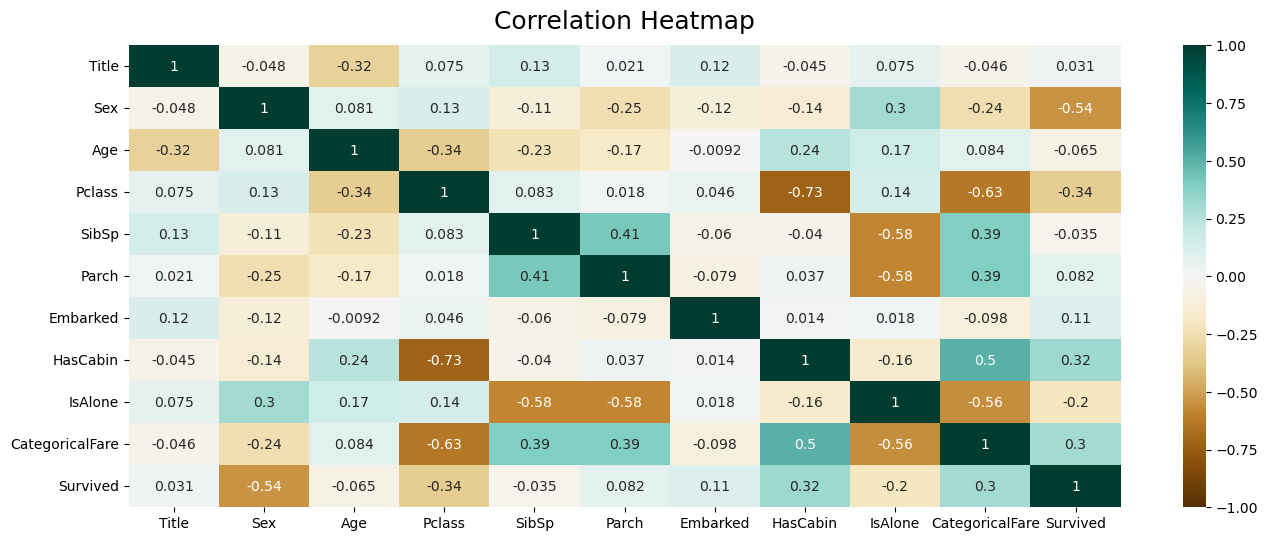

In [28]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(my_correlation, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#### IQR TO FIX OUTLIER 

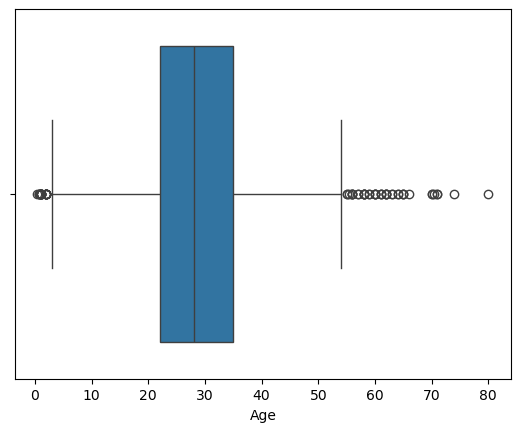

In [29]:
sns.boxplot(x=df['Age'])
plt.show()

In [30]:
df.shape

(891, 11)

In [31]:
'''
# get column names excluding 'Survived'
column_names = [col for col in df.columns.tolist() if col!= 'Survived']

for col in column_names:
    # Calculate Q1 and Q3
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Remove outliers
    df = df[~((df[col] < lower_bound) | (df[col] > upper_bound))]

print(df.shape)'''

"\n# get column names excluding 'Survived'\ncolumn_names = [col for col in df.columns.tolist() if col!= 'Survived']\n\nfor col in column_names:\n    # Calculate Q1 and Q3\n    Q1 = df[col].quantile(0.25)\n    Q3 = df[col].quantile(0.75)\n\n    # Calculate IQR\n    IQR = Q3 - Q1\n\n    # Define lower and upper bounds\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n\n    # Identify outliers\n    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]\n\n    # Remove outliers\n    df = df[~((df[col] < lower_bound) | (df[col] > upper_bound))]\n\nprint(df.shape)"

#### Z-SCORE TO FIX OUTLIER (IT'S NEED TO CALCUTER MEAN )

In [32]:
column_names = [col for col in df.columns.tolist()]
# Calculate mean and standard deviation
mean = df[column_names].mean()
std = df[column_names].std()

# Calculate z-score
z = (df[column_names] - mean) / std

# Identify outliers
outliers = (abs(z) > 3).any(axis=1)

# Remove outliers
df = df[~outliers]

print(df.shape)


(836, 11)


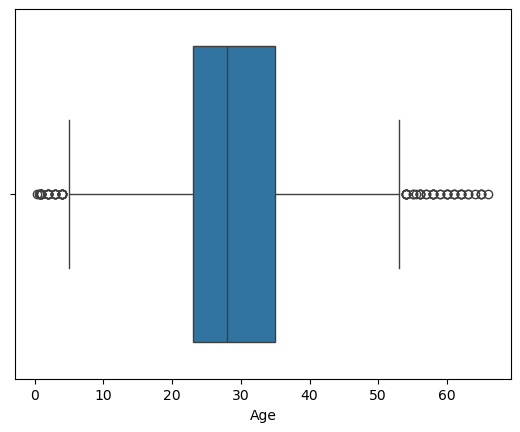

In [33]:
# نمایش نمودار جعبه‌ای برای همان ستون پس از حذف ناهنجاری‌ها
sns.boxplot(x=df['Age'])
plt.show()


In [34]:
df.isnull().sum()

Title              0
Sex                0
Age                0
Pclass             0
SibSp              0
Parch              0
Embarked           0
HasCabin           0
IsAlone            0
CategoricalFare    0
Survived           0
dtype: int64

## Strorytelling - Visualization

array([[<Axes: title={'center': 'Title'}>,
        <Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Embarked'}>,
        <Axes: title={'center': 'HasCabin'}>,
        <Axes: title={'center': 'IsAlone'}>],
       [<Axes: title={'center': 'CategoricalFare'}>,
        <Axes: title={'center': 'Survived'}>, <Axes: >]], dtype=object)

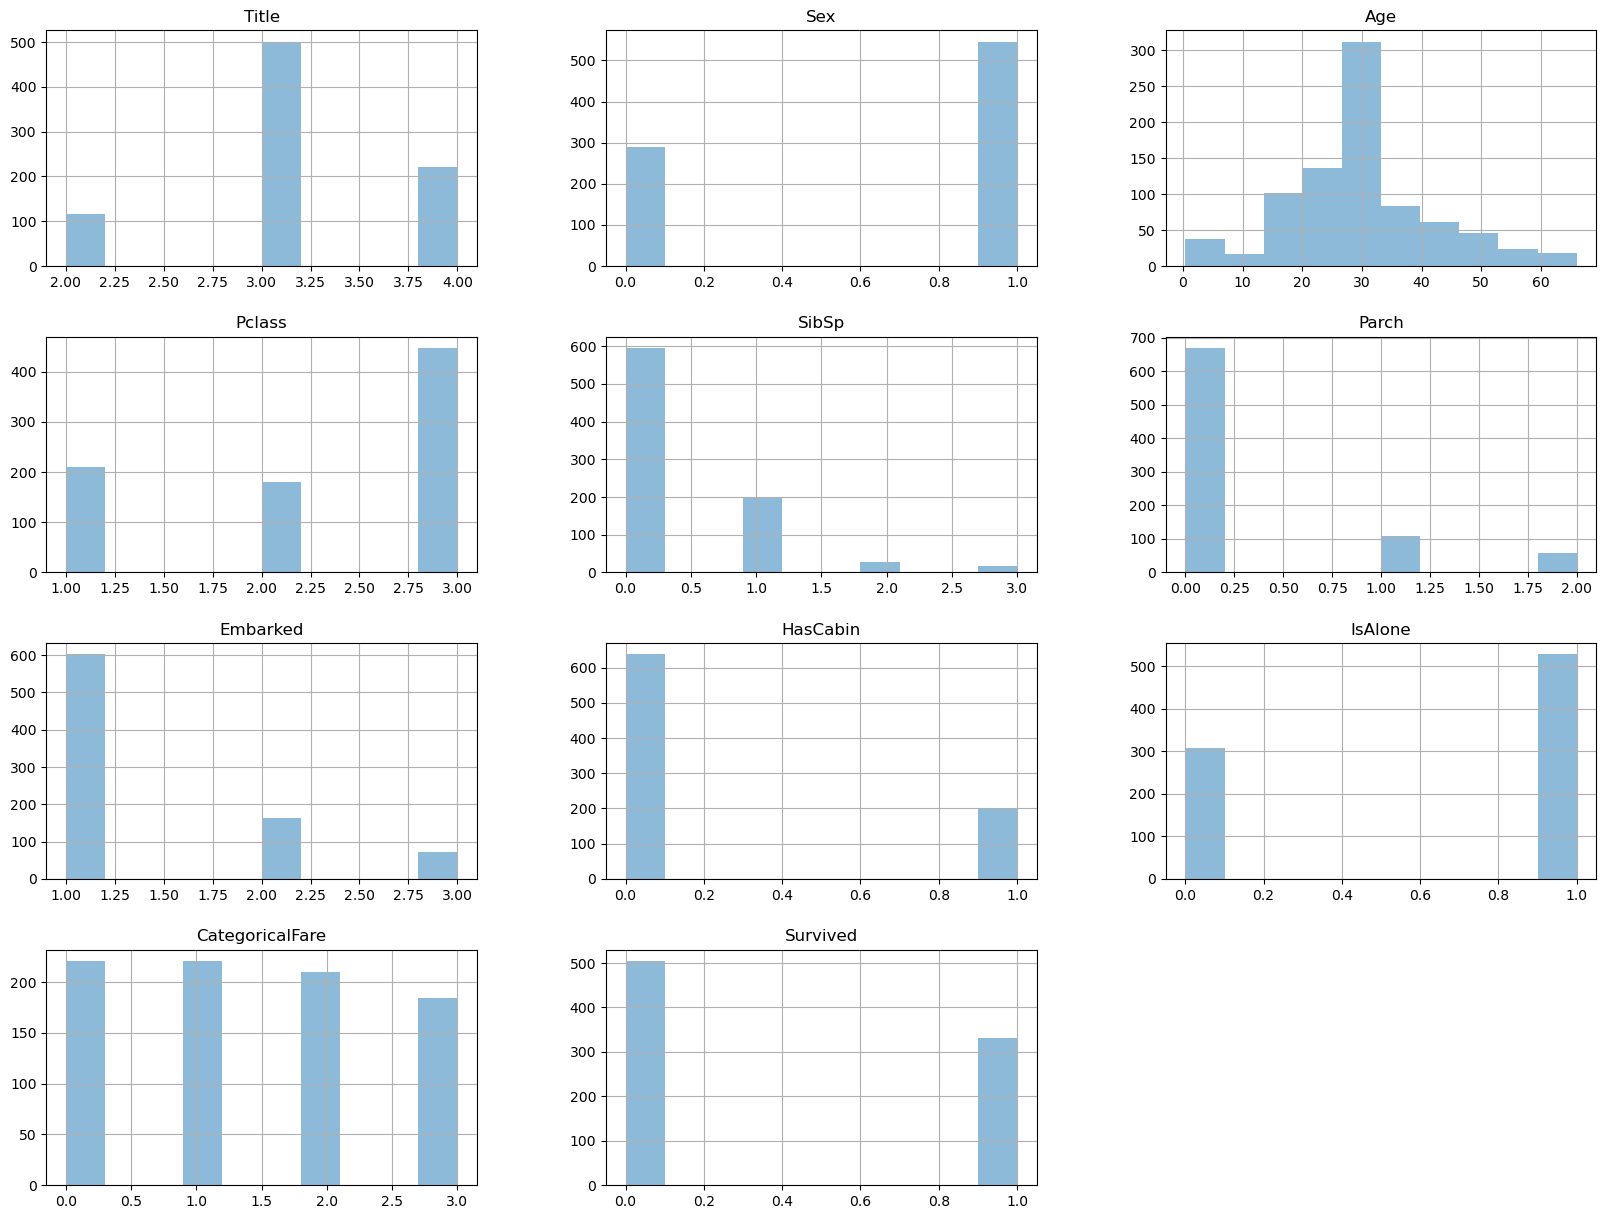

In [35]:
df.hist(alpha=0.5, figsize=(20, 15))

<Figure size 800x1200 with 0 Axes>

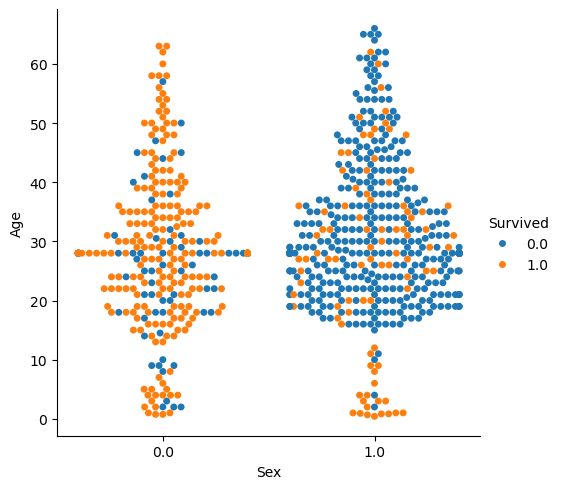

In [36]:
plt.figure(figsize=(10,15),dpi=80)
sns.catplot(data=df, x="Sex", y="Age", hue="Survived", kind="swarm")

<Axes: xlabel='Age', ylabel='Count'>

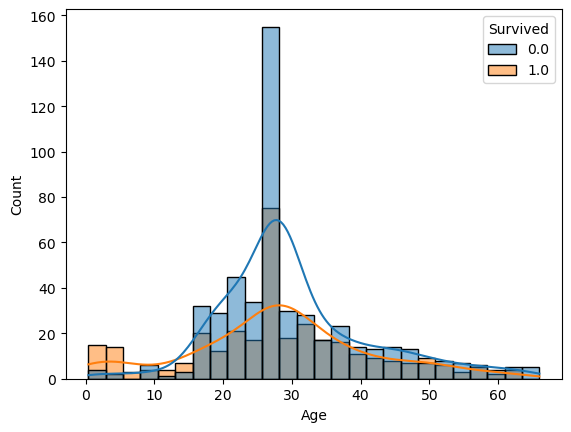

In [37]:
sns.histplot(df,x='Age',hue='Survived', kde=True)

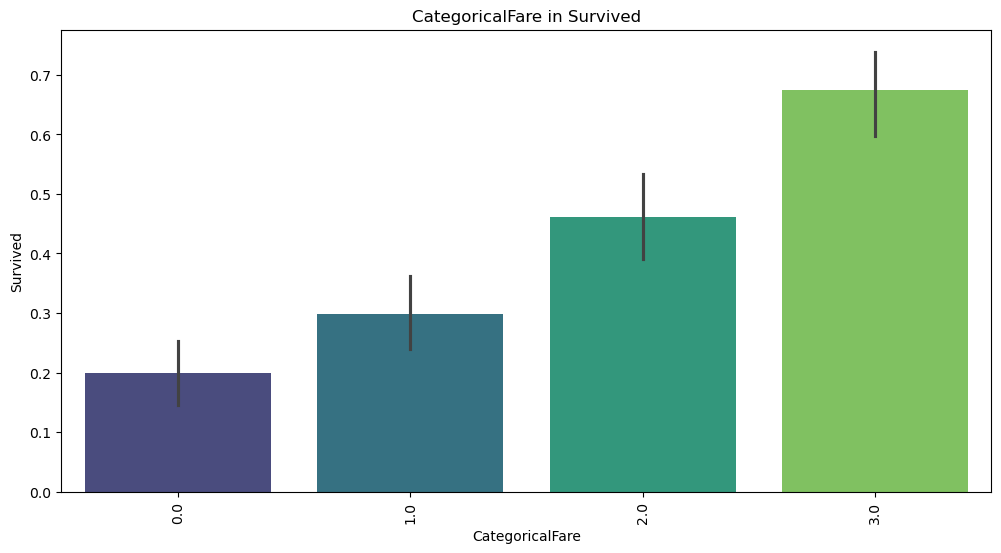

In [38]:
plt.figure(figsize=(12, 6))
sns.barplot(x='CategoricalFare',y='Survived', data=df, palette='viridis')
plt.title('CategoricalFare in Survived')
plt.xlabel('CategoricalFare')
plt.ylabel('Survived')
plt.xticks(rotation=90)
plt.show()
sns.set_theme(style="darkgrid")

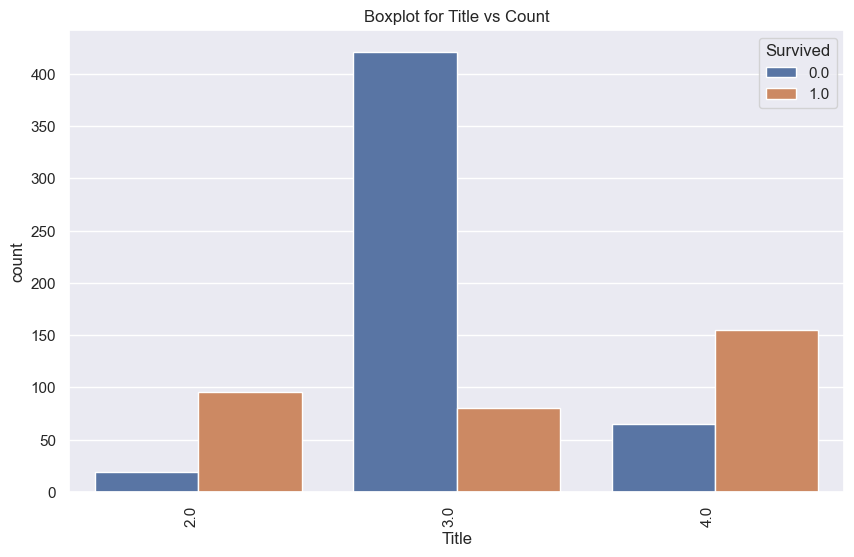

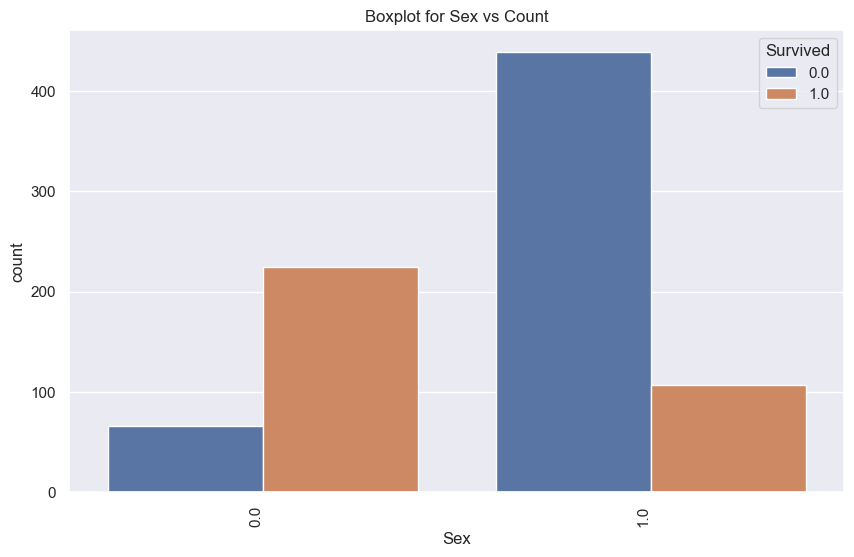

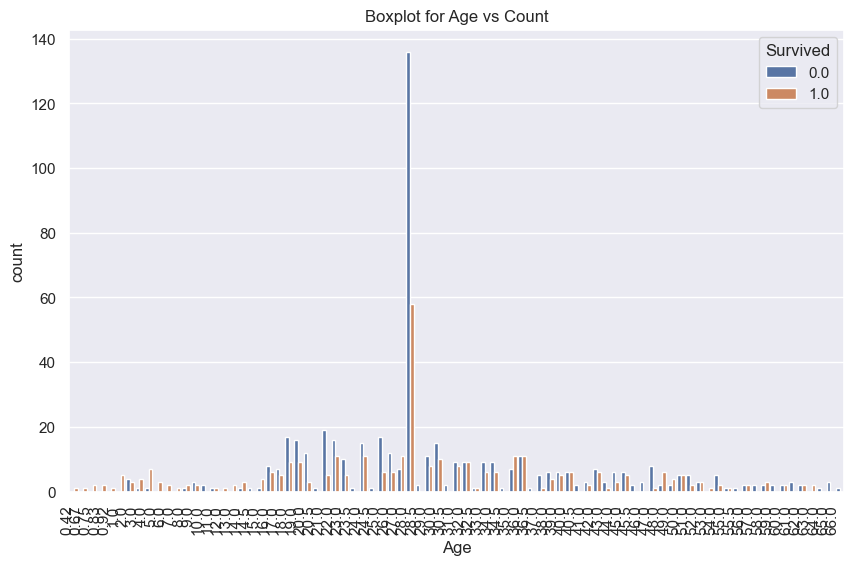

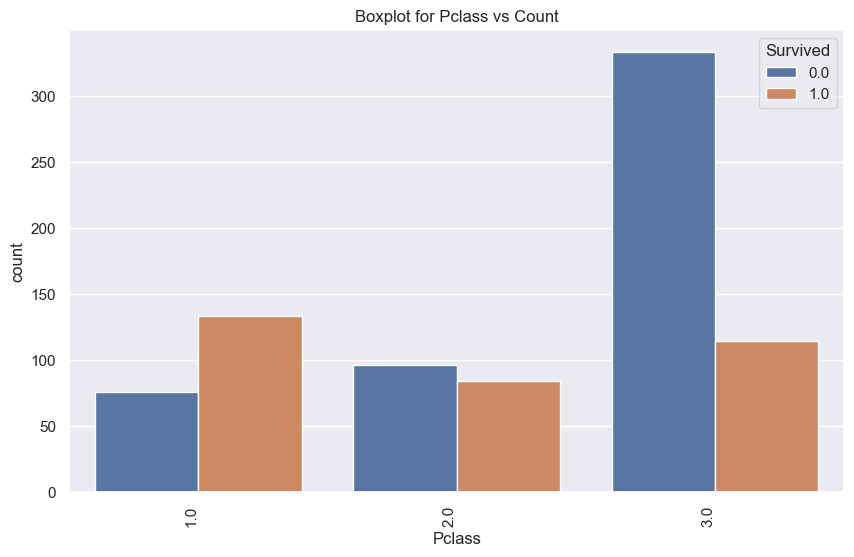

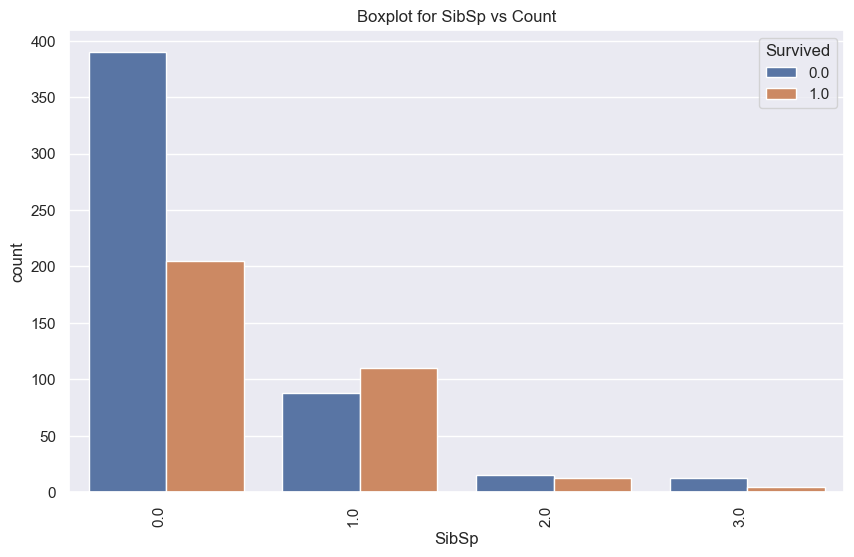

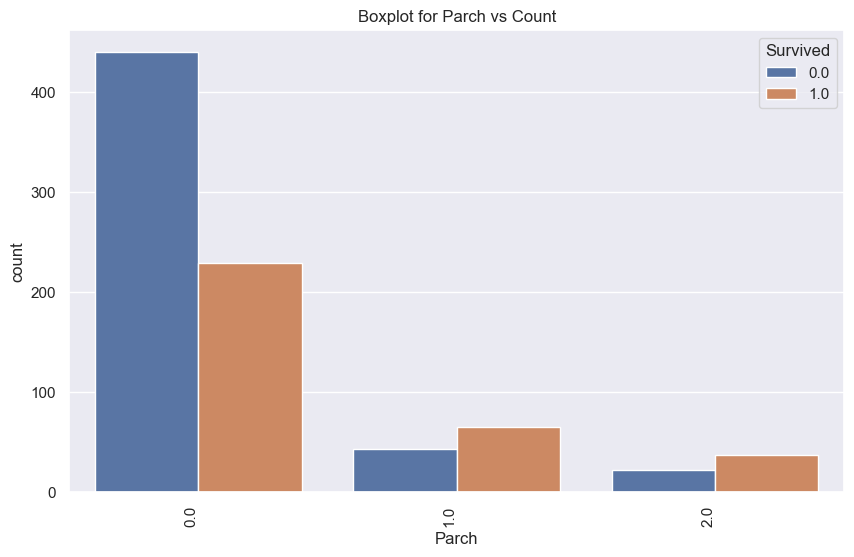

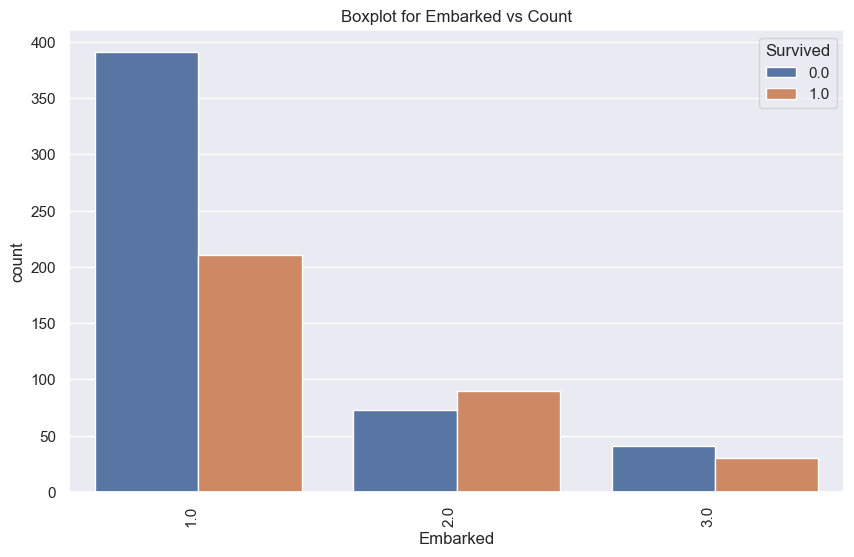

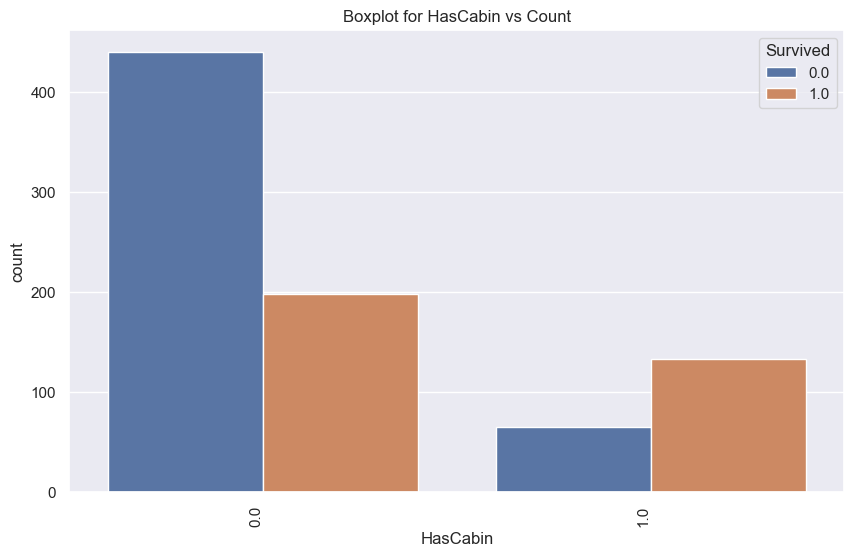

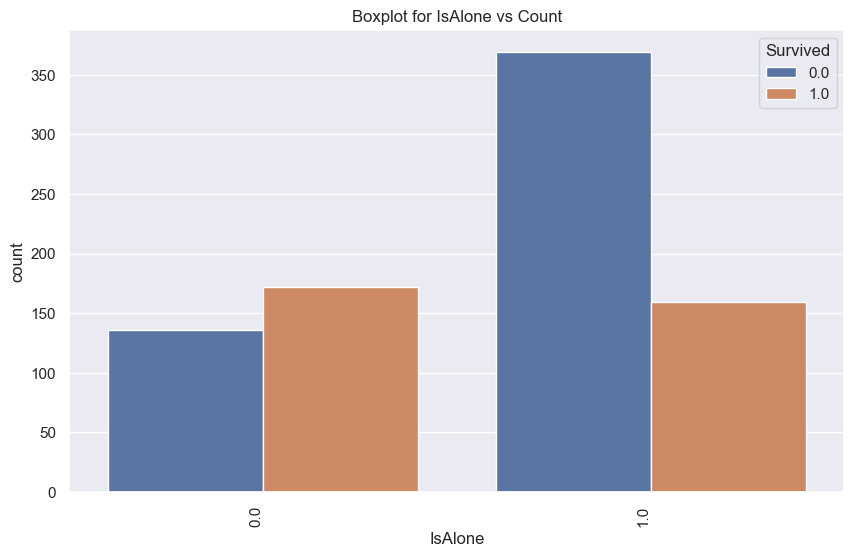

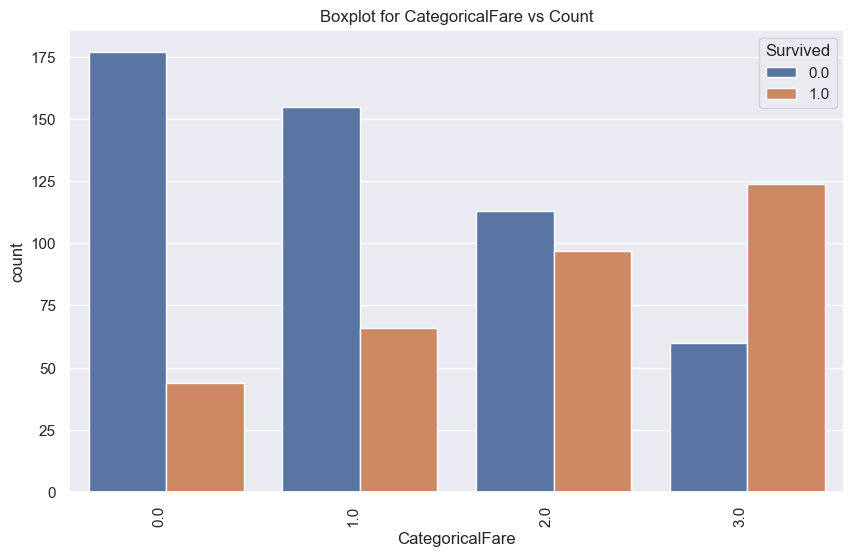

In [39]:
num_cols = ['Title', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked',
       'HasCabin', 'IsAlone', 'CategoricalFare']

for column in num_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue= 'Survived', data=df)
    
    # Rotate x-axis labels
    plt.xticks(rotation=90, ha='right')
    
    plt.title(f'Boxplot for {column} vs Count')
    plt.ylabel('count')
    plt.show()


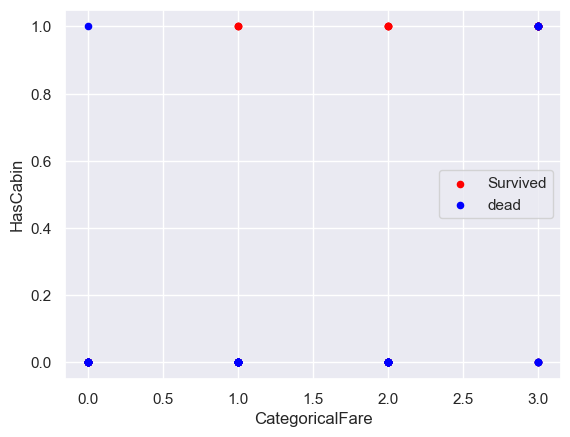

In [40]:
ax1=df[df['Survived']==1][0:50].plot(kind='scatter',x='CategoricalFare',y='HasCabin',color='red' ,label='Survived');
df[df['Survived']==0][0:50].plot(kind='scatter',x='CategoricalFare',y='HasCabin',color='blue' ,label='dead',ax=ax1);
plt.show()

In [41]:
df.columns

Index(['Title', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked',
       'HasCabin', 'IsAlone', 'CategoricalFare', 'Survived'],
      dtype='object')

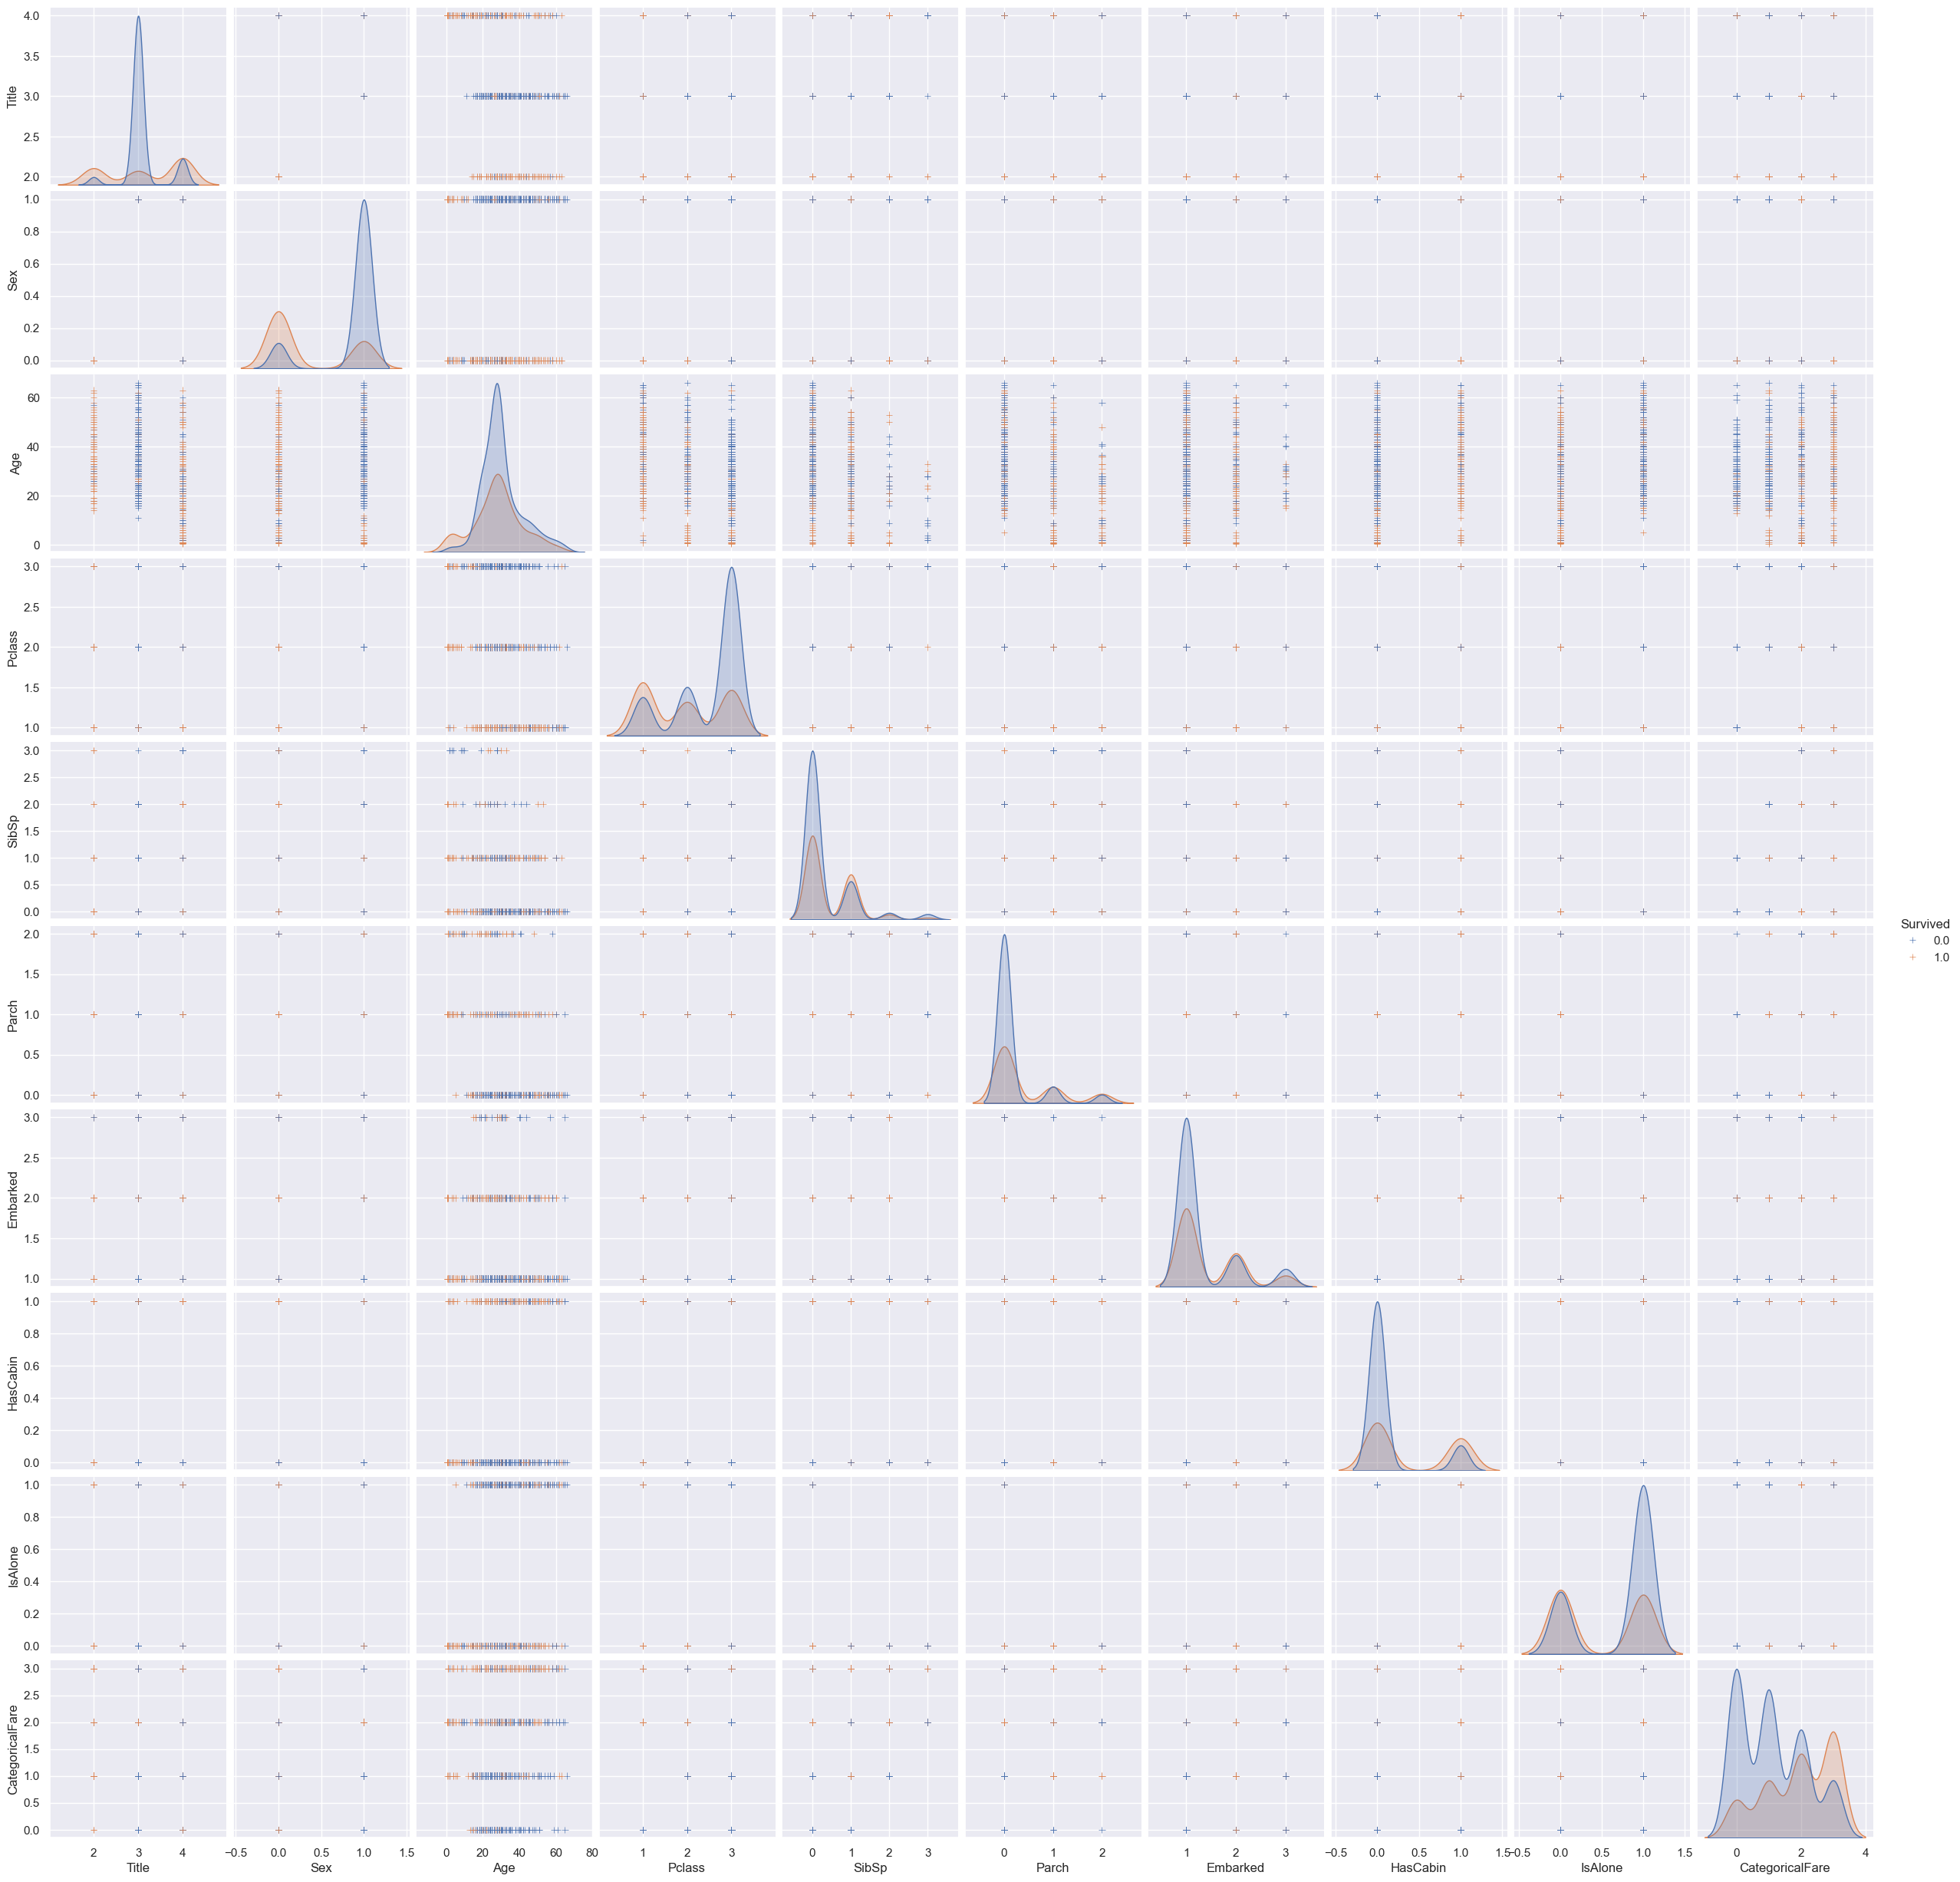

In [42]:
g=sns.pairplot(df,hue='Survived',markers='+')
plt.show()

In [43]:
import plotly.express as px

# Your DataFrame (assuming 'df' is already defined)
# ...

# Create the 3D scatter plot with a custom color scale
fig = px.scatter_3d(df, x='Sex', y='CategoricalFare', z='IsAlone', color='Survived',
                    color_continuous_scale=px.colors.sequential.Rainbow)   # Choose any other valid color scale

fig.update_traces(marker=dict(size=2))
fig.show()


## Train your model (Classification)

In [44]:
# Spliting target variable and independent variables
X = df.iloc[:,:-1]
Y = df['Survived']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 4)

In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## LogisticRegression

In [47]:
logic_r= LogisticRegression()
logic_r.fit(X_train,Y_train)

LogisticRegression()

In [48]:
Y_pred_lr=logic_r.predict(X_test)
Y_pred_lr

array([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1.

In [49]:
# Assuming `Y_test_pred` is your NumPy array with predicted labels
unique, counts = np.unique(Y_pred_lr, return_counts=True)

# Display the counts for each unique number
for number, count in zip(unique, counts):
    print(f"Number {number}: {count} times")


Number 0.0: 161 times
Number 1.0: 90 times


In [50]:
print('The accuracy of Logistic Regression is: ', (metrics.accuracy_score(Y_test, Y_pred_lr)))

The accuracy of Logistic Regression is:  0.8207171314741036


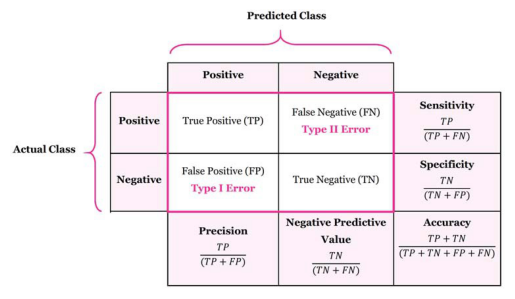

In [51]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt

# Send an HTTP GET request
url = 'https://i.sstatic.net/NzSnD.jpg'
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image and convert to a NumPy array
    image = Image.open(BytesIO(response.content))
    image_array = np.array(image)
    
    # Display the image
    plt.imshow(image_array)
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print(f"Error: {response.status_code}")


<img src="https://blog.cambridgecoaching.com/hubfs/One.png" width=60% />

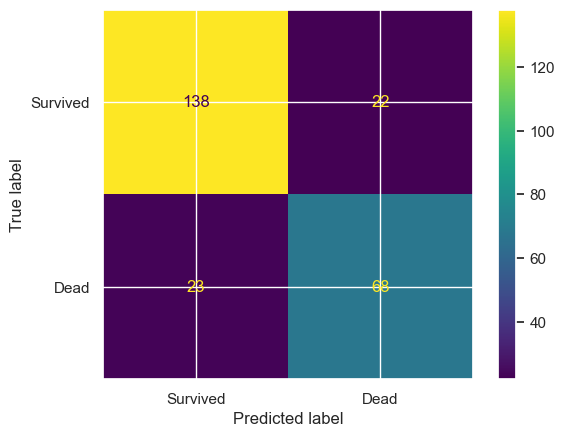

In [52]:
labels = ['Survived', 'Dead']

cm = confusion_matrix(Y_test, Y_pred_lr)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
#plt.savefig("Confusion_Matrix.png")

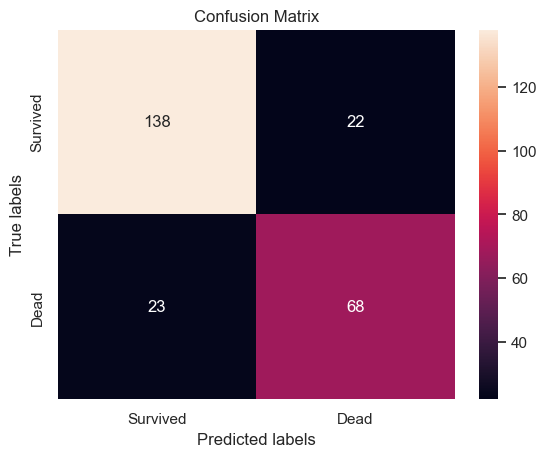

In [53]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Survived', 'Dead']); ax.yaxis.set_ticklabels(['Survived', 'Dead']);

In [54]:
target_names = ['Dead', 'Survived']
print(classification_report(Y_test, Y_pred_lr, target_names=target_names))

              precision    recall  f1-score   support

        Dead       0.86      0.86      0.86       160
    Survived       0.76      0.75      0.75        91

    accuracy                           0.82       251
   macro avg       0.81      0.80      0.81       251
weighted avg       0.82      0.82      0.82       251



# KNN Regressor

In [55]:
knn=KNeighborsClassifier()

In [56]:
k=3
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [57]:
Y_pred_knn=neigh.predict(X_test)

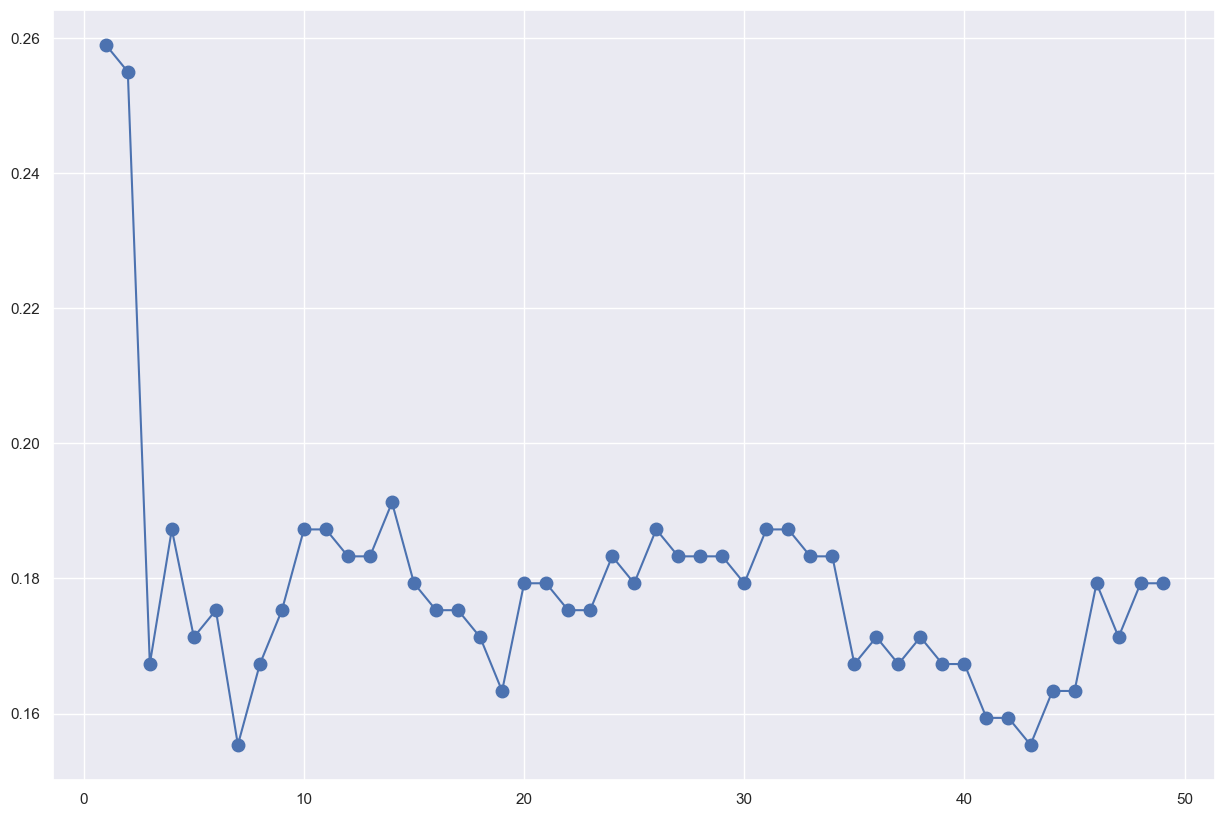

In [58]:
error_rate = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != Y_test))
plt.figure(figsize=(15,10))
plt.plot(range(1,50),error_rate, marker='o', markersize=9)

In [59]:
print(f'accuracy of Y_test , predict :{accuracy_score(Y_test, Y_pred_knn)}')
print(f'accuracy of y_train , predict :{accuracy_score(Y_train, neigh.predict(X_train))}')
print(f'classification_report of Y_test , predict :{classification_report(Y_test, Y_pred_knn)}')
print(f'confusion_matrix of Y_test , predict :{confusion_matrix(Y_test, Y_pred_knn)}')

accuracy of Y_test , predict :0.8326693227091634
accuracy of y_train , predict :0.8717948717948718
classification_report of Y_test , predict :              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       160
         1.0       0.81      0.70      0.75        91

    accuracy                           0.83       251
   macro avg       0.83      0.80      0.81       251
weighted avg       0.83      0.83      0.83       251

confusion_matrix of Y_test , predict :[[145  15]
 [ 27  64]]


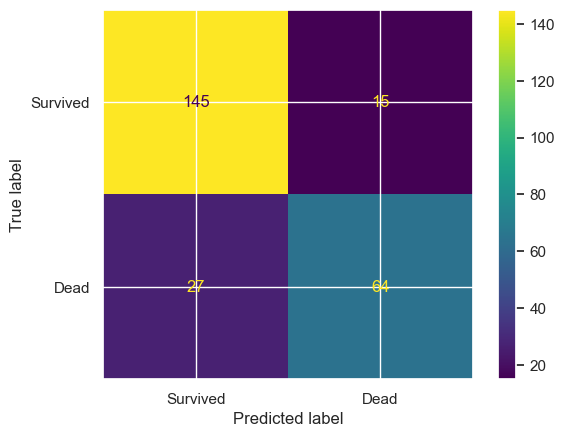

In [60]:
labels = ['Survived', 'Dead']

cm = confusion_matrix(Y_test, Y_pred_knn)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
#plt.savefig("Confusion_Matrix.png")

In [61]:
# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get best model
best_knn = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Predict on test set
y_pred = best_knn.predict(X_train)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation accuracy: 0.8085


# Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT=DecisionTreeClassifier(criterion = 'gini', random_state = 0)
classifier_DT.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=0)

In [63]:
# Define the parameter grid correctly
parameters_tree = {
    'criterion': ['gini', 'entropy'],  # choose between Gini impurity and entropy
    'max_depth': [None, 5, 10, 15],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # minimum samples required to split an internal node
    'min_samples_leaf': [1, 5, 10],  # minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # maximum features to consider at each split
}

In [64]:
grid_search_tree=GridSearchCV(estimator=classifier_DT,
                        param_grid=parameters_tree,
                        scoring='accuracy',
                        cv=10,
                        n_jobs = -1)

In [65]:
grid_search_tree.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [66]:
best_accuracy = grid_search_tree.best_score_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))

Best Accuracy: 77.97 %


In [67]:
best_parameters = grid_search_tree.best_params_
print("Best Parameters:", best_parameters)

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}


In [68]:
Y_pred_DT = classifier_DT.predict(X_test)

In [69]:
df.columns

Index(['Title', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked',
       'HasCabin', 'IsAlone', 'CategoricalFare', 'Survived'],
      dtype='object')

In [70]:
feature_names = ['Title', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked',
       'HasCabin', 'IsAlone', 'CategoricalFare']
dot_data = export_graphviz(classifier_DT, out_file=None,
                           feature_names=feature_names,
                           class_names=["servived_tree", "dead"],
                           filled=True)

graph = graphviz.Source(dot_data, format="png")
graph.render("servived_tree")  # Save the tree to a file
graph.view("servived_tree")

'servived_tree.png'

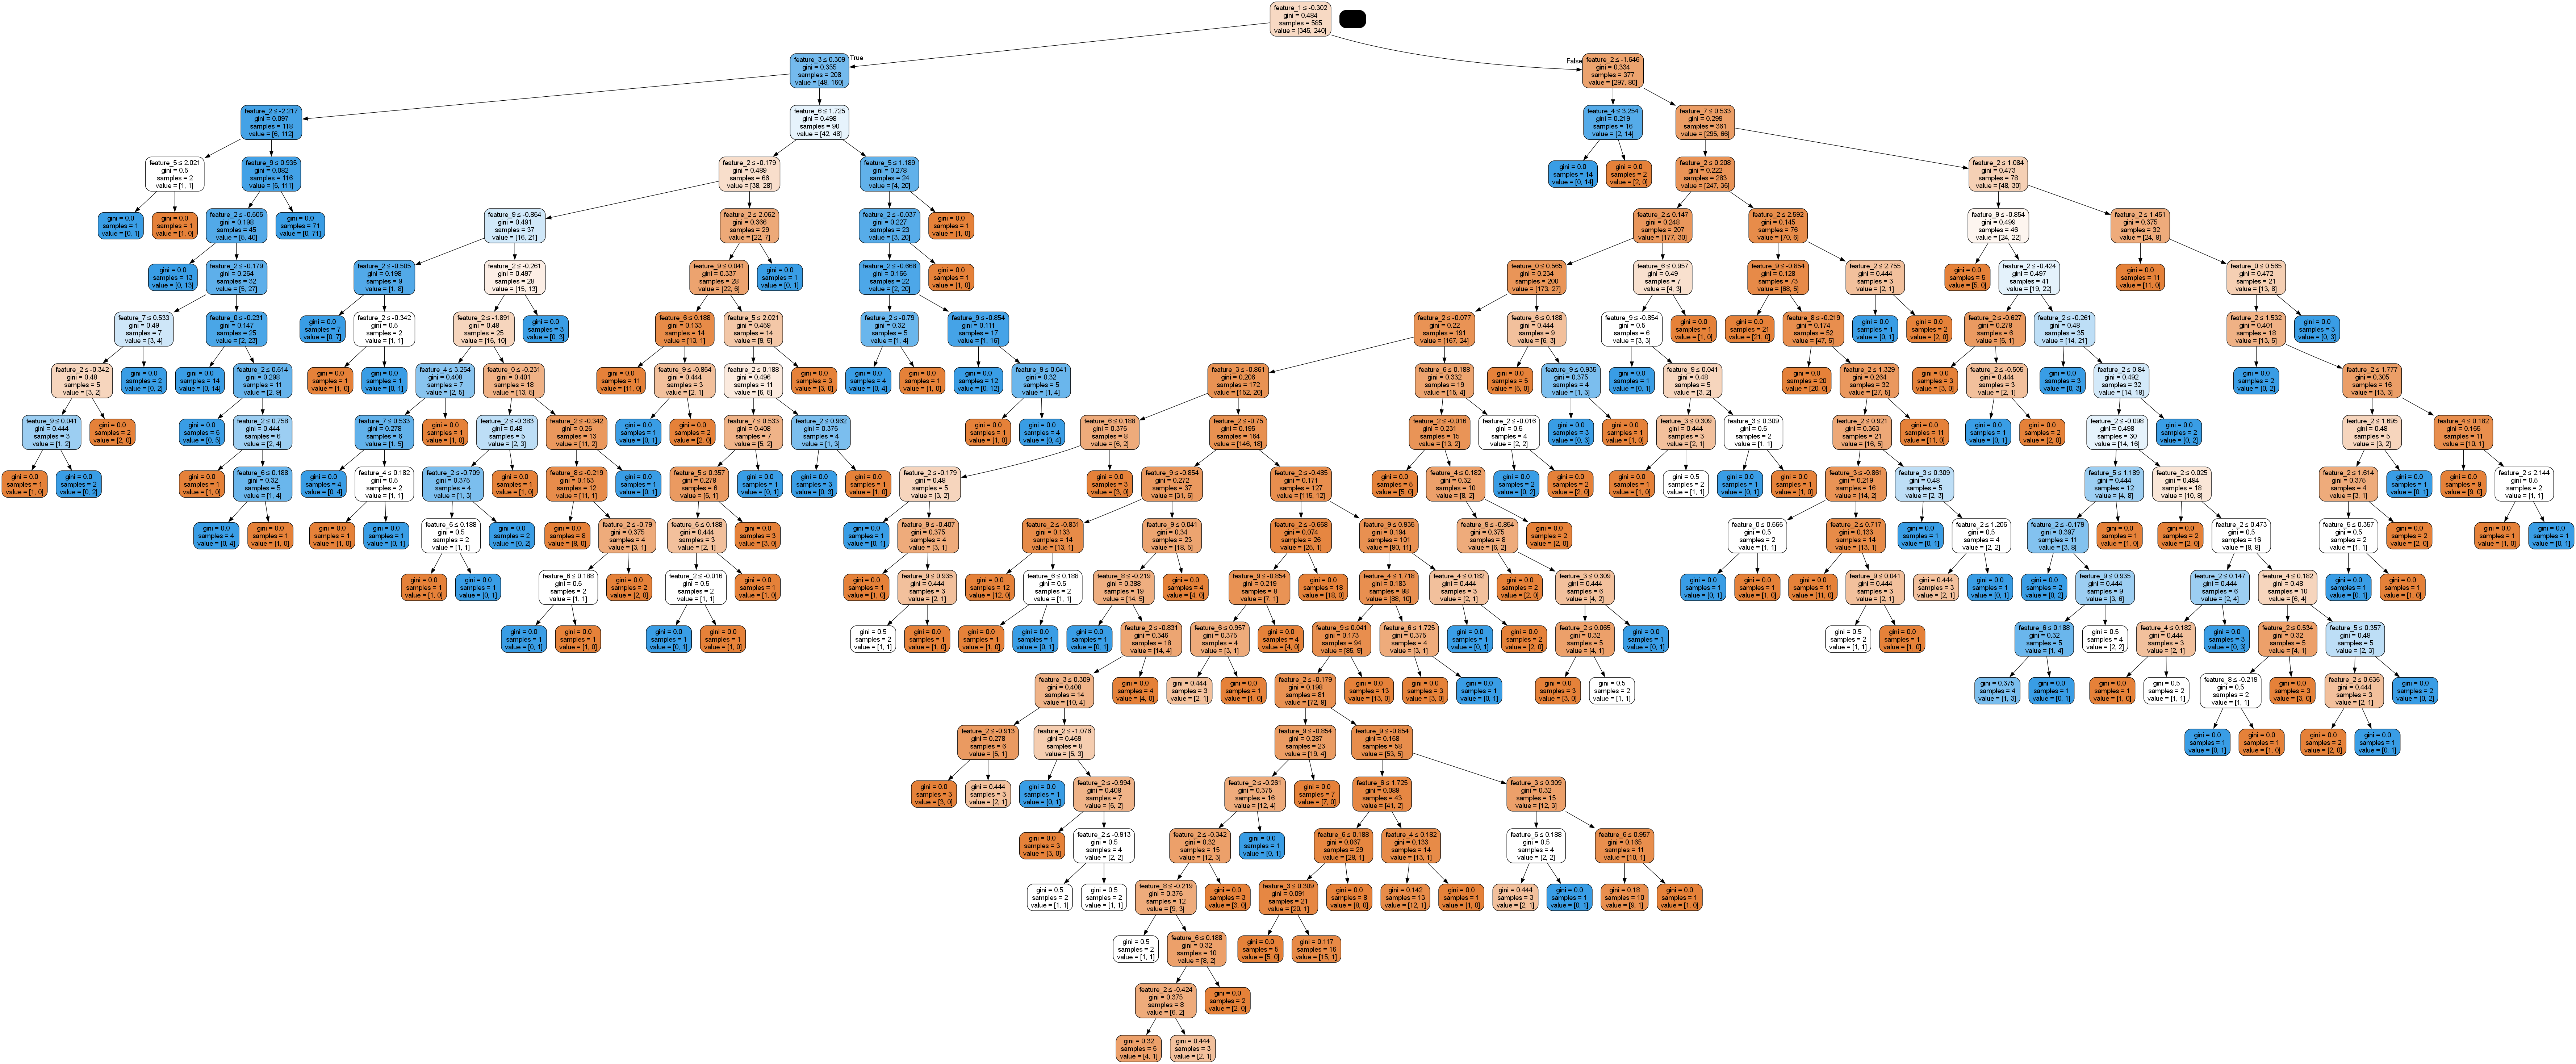

In [71]:
from IPython.display import Image
# Create DOT data
dot_data = StringIO()
export_graphviz(classifier_DT, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=[f'feature_{i}' for i in range(X_train.shape[1])])

# Create the graph from DOT data
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Display the decision tree
image = Image(graph.create_png())
display(image)

In [72]:
accuracies_tree=cross_val_score(estimator=classifier_DT,X=X_train,y=Y_train,cv=10)

In [73]:
print(f"Accuracy: {accuracies_tree.mean()*100}")
print(f"Standard Deviation: {accuracies_tree.std()*100}")

Accuracy: 77.96025715955581
Standard Deviation: 5.7704361745191575


In [74]:
print(f'accuracy of Y_test , predict :{accuracy_score(Y_test, Y_pred_DT)}')
print(f'accuracy of y_train , predict :{accuracy_score(Y_train, neigh.predict(X_train))}')
print(f'classification_report of Y_test , predict :{classification_report(Y_test, Y_pred_DT)}')
print(f'confusion_matrix of Y_test , predict :{confusion_matrix(Y_test, Y_pred_DT)}')

accuracy of Y_test , predict :0.8127490039840638
accuracy of y_train , predict :0.8717948717948718
classification_report of Y_test , predict :              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       160
         1.0       0.73      0.77      0.75        91

    accuracy                           0.81       251
   macro avg       0.80      0.80      0.80       251
weighted avg       0.82      0.81      0.81       251

confusion_matrix of Y_test , predict :[[134  26]
 [ 21  70]]


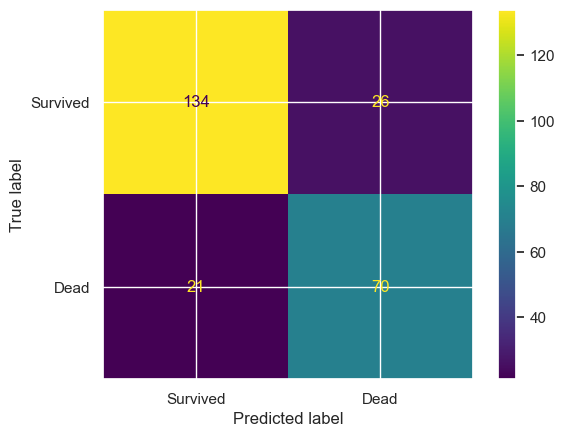

In [75]:
labels = ['Survived', 'Dead']

cm = confusion_matrix(Y_test, Y_pred_DT)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
#plt.savefig("Confusion_Matrix.png")

## random forest

In [76]:
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
rfc.fit(X_train, Y_train)

# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)
print('Training Set Evaluation F1-Score=>',f1_score(Y_train,rfc_pred_train))

Training Set Evaluation F1-Score=> 0.9570815450643777


In [77]:
# Define the parameter grid correctly
parameters_rf = {
    'criterion': ['gini', 'entropy'],  # choose between Gini impurity and entropy
    'max_depth': [None, 5, 10, 15],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # minimum samples required to split an internal node
    'min_samples_leaf': [1, 5, 10],  # minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # maximum features to consider at each split
}


In [78]:
# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rfc,
                              param_grid=parameters_rf,
                              scoring='f1',  # use 'f1' for the F1 score
                              cv=10,
                              n_jobs=-1)


In [79]:
grid_search_rf.fit(X_train,Y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [80]:
# Get the best parameters
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

print("Best Parameters: ", best_params)
print("Best Cross-Validation F1-Score: ", best_score)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Cross-Validation F1-Score:  0.7656626320188739


In [81]:
# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)
print('Testing Set Evaluation F1-Score=>',f1_score(Y_test,rfc_pred_test))

Testing Set Evaluation F1-Score=> 0.7564766839378239


## svm

In [82]:
svclassifier=SVC(kernel='linear')
svclassifier.fit(X_train, Y_train)

SVC(kernel='linear')

In [83]:
y_pred_svc = svclassifier.predict(X_test)

In [84]:
accuracies_svc=cross_val_score(estimator=svclassifier,X=X_train,y=Y_train,cv=10)

In [85]:
print(f"Accuracy: {accuracies_svc.mean()*100}")
print(f"Standard Deviation: {accuracies_svc.std()*100}")

Accuracy: 78.14143775569843
Standard Deviation: 6.231848023256134


In [86]:
# Define the parameter grid correctly for SVC
parameters_svc = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [3, 4, 5]  # Degree of the polynomial kernel function (only relevant for 'poly')
}


In [87]:
# Perform GridSearchCV
grid_search_svc = GridSearchCV(estimator=svclassifier,
                               param_grid=parameters_svc,
                               scoring='accuracy',  # or 'f1' if you prefer
                               cv=10,
                               n_jobs=-1)

In [88]:
grid_search_svc.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [89]:
# Get the best parameters
best_params = grid_search_svc.best_params_
best_score = grid_search_svc.best_score_

print("Best Parameters: ", best_params)
print("Best Cross-Validation F1-Score: ", best_score)

Best Parameters:  {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation F1-Score:  0.8001753360607833


In [90]:
print(f'accuracy of Y_test , predict :{accuracy_score(Y_test, y_pred_svc)}')
print(f'accuracy of y_train , predict :{accuracy_score(Y_train, neigh.predict(X_train))}')
print(f'classification_report of Y_test , predict :{classification_report(Y_test, y_pred_svc)}')
print(f'confusion_matrix of Y_test , predict :{confusion_matrix(Y_test, y_pred_svc)}')

accuracy of Y_test , predict :0.8207171314741036
accuracy of y_train , predict :0.8717948717948718
classification_report of Y_test , predict :              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       160
         1.0       0.78      0.70      0.74        91

    accuracy                           0.82       251
   macro avg       0.81      0.80      0.80       251
weighted avg       0.82      0.82      0.82       251

confusion_matrix of Y_test , predict :[[142  18]
 [ 27  64]]


## XGBoost

In [91]:
Xgb_df=xgb.XGBRFRegressor( n_estimators=1000,
                            learning_rate=1,
                            subsample=1,
                            colsample_bytree=1, 
                            max_depth=8,
                            gamma=1  
                           )
Xgb_df.fit(X_train,Y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=1, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=1, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None,
               n_estimators=1000, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', random_state=None, ...)

In [92]:
Y_pred_xgb = Xgb_df.predict(X_test)

In [93]:
# Define the parameter grid for XGBRFRegressor
parameters_xgb = {
    'n_estimators': [100, 500, 1000],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.3, 0.5],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1],  # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.8, 1],  # Subsample ratio of columns when constructing each tree
    'max_depth': [3, 5, 7, 9],  # Maximum depth of a tree
    'gamma': [0, 0.1, 0.3, 0.5]  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

In [94]:
# Perform GridSearchCV
grid_search_xgb = GridSearchCV(estimator=Xgb_df,
                               param_grid=parameters_xgb,
                               scoring='r2',  # Adjust according to your evaluation metric
                               cv=10,
                               n_jobs=-1)


In [95]:
# Fit the model with the grid search
grid_search_xgb.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bytree=1, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=1, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=1, max_bin=None,
                                      max_cat_threshol...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=1000,
                                      n_jobs=None, num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'gamma': [0, 0.1, 0.3, 0.5],
                         'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.6, 0.8, 1]},
             scoring='r2')

In [96]:

# Get the best parameters
best_params = grid_search_xgb.best_params_
best_score = grid_search_xgb.best_score_


print("Best Parameters: ", best_params)
print("Best Cross-Validation Score: ", best_score)

Best Parameters:  {'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
Best Cross-Validation Score:  0.3183347383456677


In [97]:
sorce_xgb=cross_val_score(Xgb_df,X_train,Y_train,cv=10)
print(f"accurecy: {sorce_xgb.mean()}")
print(f"Standard Deviation: {sorce_xgb.std()*100}")

accurecy: 0.41678114415717654
Standard Deviation: 9.379824330194811


In [98]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_xgb))
print("RMSE: %f" % (rmse))

RMSE: 0.353027


In [99]:
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(Y_test, Y_pred_xgb))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.678775


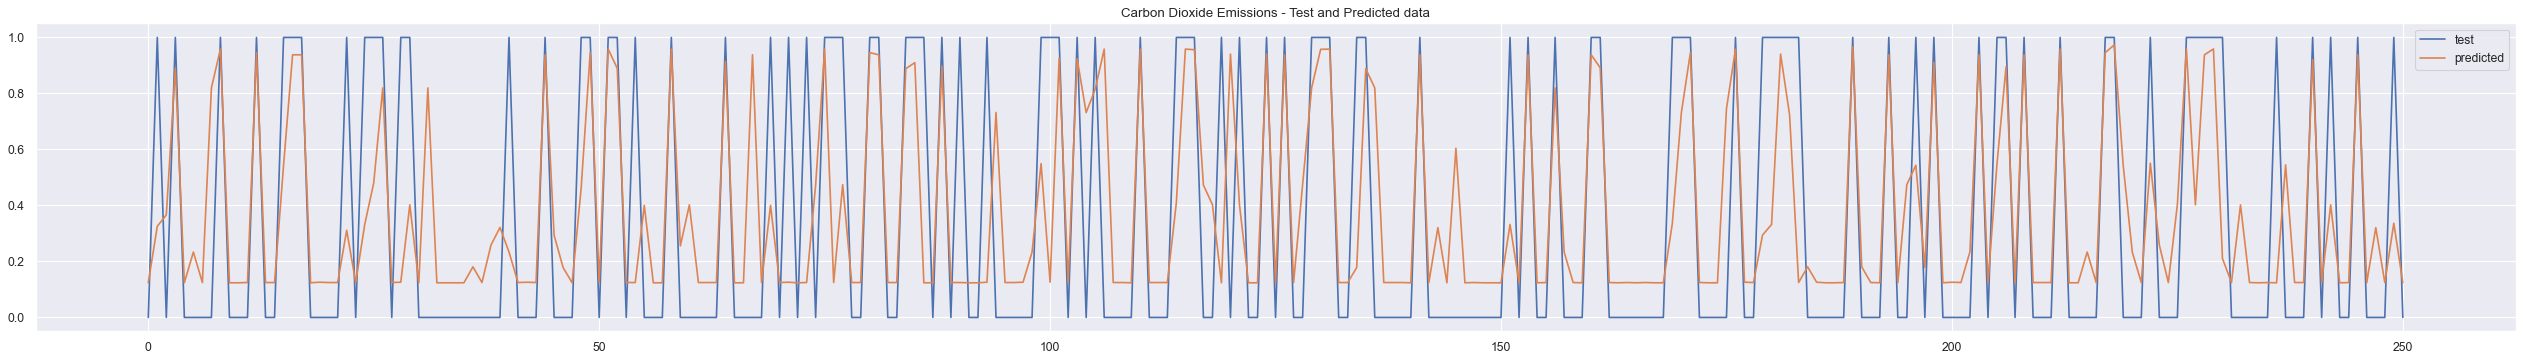

In [100]:
plt.figure(figsize=(40, 5), dpi=80)
x_ax = range(len(Y_test))
plt.plot(x_ax, Y_test, label="test")
plt.plot(x_ax, Y_pred_xgb, label="predicted")
plt.title("Carbon Dioxide Emissions - Test and Predicted data")
plt.legend()
plt.show()

## Test Result

In [101]:
df_test=pd.read_csv('test.csv')
df_test

PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0              330911    7.8292   NaN        Q  
1    female  47.0      1      0              363272    7.0000   NaN        S  
2      male  62.0      0      0              240276    9.6875   NaN        Q  
3      male  27.0      0      0              315154    8.6625   NaN        S  
4    female  22.0      1      1             3101298   12.2875   NaN        S  
..      ...   ...    ...    ...                 ...       ...   ...      ...  
413    male   NaN      0      0           A.5. 3236    8.0500   NaN        S  
414  female  39.0      0      0            PC 17758  108.9000  C105        C  
415    male  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416    male   NaN      0      0              359309    8.0500   NaN        S  
417    male   NaN      1      1                2668   22.3583   NaN        C  

[418 rows x 11 columns]

In [102]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [103]:
df_test.describe()

PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200

In [104]:
df_test = df_test.reindex(columns=['PassengerId','Name','Sex','Age','Pclass','SibSp','Parch','Ticket','Fare','Cabin','Embarked'])

In [105]:
df_test

PassengerId                                          Name     Sex   Age  \
0            892                              Kelly, Mr. James    male  34.5   
1            893              Wilkes, Mrs. James (Ellen Needs)  female  47.0   
2            894                     Myles, Mr. Thomas Francis    male  62.0   
3            895                              Wirz, Mr. Albert    male  27.0   
4            896  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0   
..           ...                                           ...     ...   ...   
413         1305                            Spector, Mr. Woolf    male   NaN   
414         1306                  Oliva y Ocana, Dona. Fermina  female  39.0   
415         1307                  Saether, Mr. Simon Sivertsen    male  38.5   
416         1308                           Ware, Mr. Frederick    male   NaN   
417         1309                      Peter, Master. Michael J    male   NaN   

     Pclass  SibSp  Parch              Ticket      Fare Cabin Embarked  
0         3      0      0              330911    7.8292   NaN        Q  
1         3      1      0              363272    7.0000   NaN        S  
2         2      0      0              240276    9.6875   NaN        Q  
3         3      0      0              315154    8.6625   NaN        S  
4         3      1      1             3101298   12.2875   NaN        S  
..      ...    ...    ...                 ...       ...   ...      ...  
413       3      0      0           A.5. 3236    8.0500   NaN        S  
414       1      0      0            PC 17758  108.9000  C105        C  
415       3      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416       3      0      0              359309    8.0500   NaN        S  
417       3      1      1                2668   22.3583   NaN        C  

[418 rows x 11 columns]

In [106]:
def create_feat_has_cabin(df_test, colname):
    # if NA => 0 else 1
    def _is_nan(x):
        if isinstance(x, type(np.nan)):
            return 0
        return 1
        
    return df_test[colname].apply(_is_nan)
    
df_test['HasCabin'] = create_feat_has_cabin(df_test, 'Cabin')

In [107]:
def fill_na_embarked(df_test, colname):
    
    return df_test[colname].fillna('S')
    
df_test['Embarked'] = fill_na_embarked(df_test, 'Embarked')

In [108]:
def create_feat_familly_size(df):
    return df['SibSp'] + df_test['Parch'] + 1
    
df_test['FamilySize'] = create_feat_familly_size(df_test)

In [109]:
def create_feat_isalone(df, colname):
    def _is_alone(x):
        if x==1:
            return 1
        return 0
    
    return df_test[colname].apply(_is_alone)
    
df_test['IsAlone'] = create_feat_isalone(df_test, 'FamilySize')

In [110]:
# پرکردن مقادیر گمشده:
# - عددی‌ها با میانه همان ستون
num_cols = df_test.select_dtypes(include=['number']).columns
for c in num_cols:
    df_test[c] = df_test[c].fillna(df_test[c].median())

In [111]:
# - دسته‌ای/رشته‌ای‌ها با مُد هر ستون (اگر مُد نبود، با رشتهٔ 'Unknown')
cat_cols = df_test.select_dtypes(include=['object', 'category']).columns
for c in cat_cols:
    if df_test[c].isna().all():
        df_test[c] = df_test[c].fillna('Unknown')
    else:
        df_test[c] = df_test[c].fillna(df_test[c].mode().iloc[0])

In [112]:
df_test['Sex'] = df_test['Sex'].astype('category').cat.codes.astype(float)
df_test['Embarked'].replace(to_replace=['S', 'C', 'Q'], value=[1, 2, 3], inplace=True)

In [113]:
def create_feat_categoricalFare(df_test, colname):
    return pd.qcut(df_test[colname], 4, labels = [0, 1, 2, 3]).astype(int)
df_test['CategoricalFare'] = create_feat_categoricalFare(df_test, 'Fare')

In [114]:
def create_feat_title(df_test, colname):
    def find_title(z):
        title_search = re.search(' ([A-Za-z]+)\.', z)
        if title_search:
            title = title_search.group(1)
            if title in ['Mlle', 'Ms']:
                return 'Miss'
            elif title in ['Mme', 'Mrs']:
                return 'Mrs'
            elif title=='Mr':
                return 'Mr'           
            else:
                return 'Rare'
        return ""
    
    return_title= df_test[colname].apply(find_title)
    dict_title = {'Miss': 1, 'Mrs':2, 'Mr':3, 'Rare':4}
    return return_title.replace(dict_title)
df_test['Title'] = create_feat_title(df_test, 'Name')

In [115]:
df_test.drop(columns=['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [116]:
df_test = df_test.reindex(columns=['Title','Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked',
        'HasCabin', 'IsAlone', 'CategoricalFare'])

In [117]:
df_test = df_test.astype(float)

In [118]:
df_test

Title  Sex   Age  Pclass  SibSp  Parch  Embarked  HasCabin  IsAlone  \
0      3.0  1.0  34.5     3.0    0.0    0.0       3.0       0.0      1.0   
1      2.0  0.0  47.0     3.0    1.0    0.0       1.0       0.0      0.0   
2      3.0  1.0  62.0     2.0    0.0    0.0       3.0       0.0      1.0   
3      3.0  1.0  27.0     3.0    0.0    0.0       1.0       0.0      1.0   
4      2.0  0.0  22.0     3.0    1.0    1.0       1.0       0.0      0.0   
..     ...  ...   ...     ...    ...    ...       ...       ...      ...   
413    3.0  1.0  27.0     3.0    0.0    0.0       1.0       0.0      1.0   
414    4.0  0.0  39.0     1.0    0.0    0.0       2.0       1.0      1.0   
415    3.0  1.0  38.5     3.0    0.0    0.0       1.0       0.0      1.0   
416    3.0  1.0  27.0     3.0    0.0    0.0       1.0       0.0      1.0   
417    4.0  1.0  27.0     3.0    1.0    1.0       2.0       0.0      0.0   

     CategoricalFare  
0                0.0  
1                0.0  
2                1.0  
3                1.0  
4                1.0  
..               ...  
413              1.0  
414              3.0  
415              0.0  
416              1.0  
417              2.0  

[418 rows x 10 columns]

In [119]:
X_df_test=df_test.iloc[:,:].values

In [120]:
Y_pred_knn_final_test=neigh.predict(X_df_test)

Key Results / Performance

* **K-Nearest Neighbors (KNN)** achieved the highest accuracy among the tested models in this project.
* Some experiments also utilized **cross-validation** to better estimate model performance and reduce variance in accuracy scores.
* Decision Tree Classifier and other models were also implemented for comparison.
* Demonstrated ability to handle missing data, engineer meaningful features, and visualize results.
